# Exploring Mental Health processed data EDA 

In [1]:
import pandas as pd
import numpy as np 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
train_path = "../data/processed/processed_train.csv"
val_path = "../data/processed/processed_val.csv"
test_path = "../data/processed/processed_test.csv"

train = pd.read_csv(train_path)
val = pd.read_csv(val_path)
test = pd.read_csv(test_path)

In [3]:
train.describe()

,Gender_Female,Gender_Male,Working Professional or Student_Student,Working Professional or Student_Working Professional,Sleep Duration_5-6 hours,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_other,Dietary Habits_Healthy,...,Family History of Mental Illness_No,Family History of Mental Illness_Yes,id,Age,CGPA,Work/Study Hours,Financial Stress,Pressure,Satisfaction,Depression
count,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,...,112560.000000,112560.000000,112560.000000,112560.000000,22382.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000
mean,0.450426,0.549574,0.198872,0.801128,0.227923,0.263895,0.275729,0.231894,0.000560,0.317626,...,0.503207,0.496793,70338.238086,40.358502,7.661638,6.250480,2.985981,3.024494,2.966462,0.182356
std,0.497539,0.497539,0.399153,0.399153,0.419494,0.440745,0.446883,0.422044,0.023651,0.465555,...,0.499992,0.499992,40605.872864,12.383195,1.468060,3.848087,1.412195,1.402434,1.404912,0.386139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,18.000000,5.030000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,35204.750000,29.000000,6.282500,3.000000,2.000000,2.000000,2.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,70288.500000,42.000000,7.770000,6.000000,3.000000,3.000000,3.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,105479.250000,51.000000,8.930000,10.000000,4.000000,4.000000,4.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,140695.000000,60.000000,10.000000,12.000000,5.000000,5.000000,5.000000,1.000000


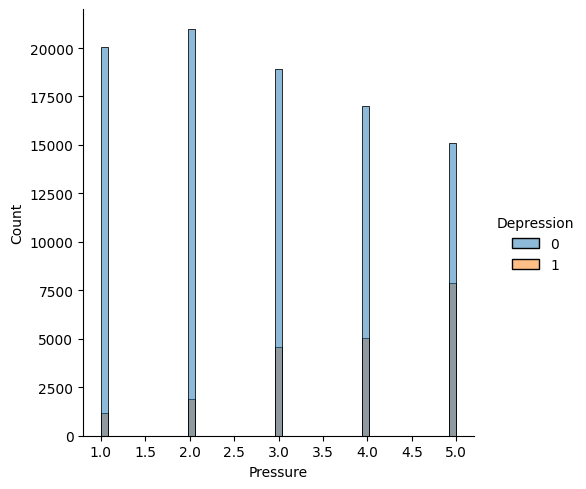

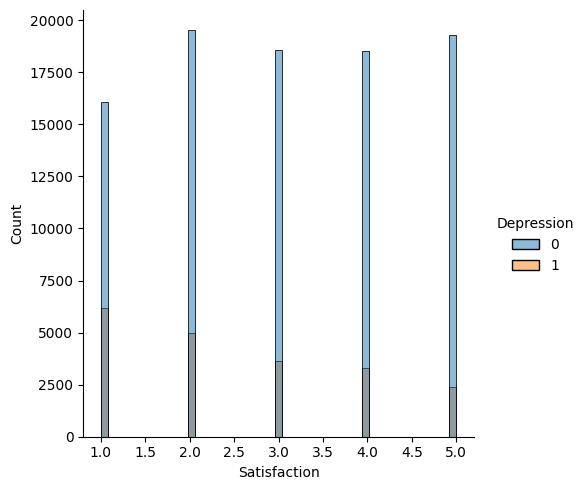

In [4]:
sns.displot(train, x="Pressure", hue="Depression")
sns.displot(train, x="Satisfaction", hue="Depression")

<Axes: xlabel='Depression', ylabel='Pressure'>

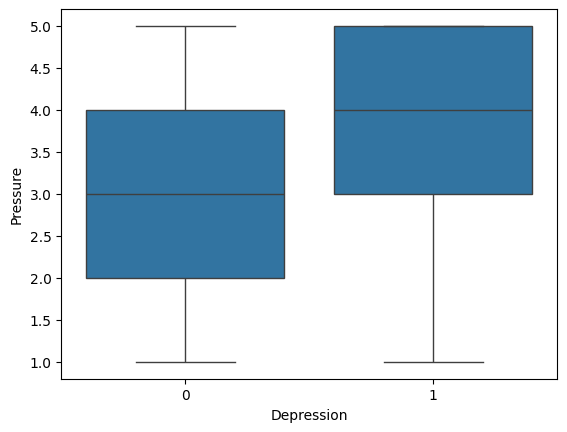

In [5]:
# For continuous features
sns.boxplot(train, x="Depression", y="Pressure")


<Axes: xlabel='Depression', ylabel='Satisfaction'>

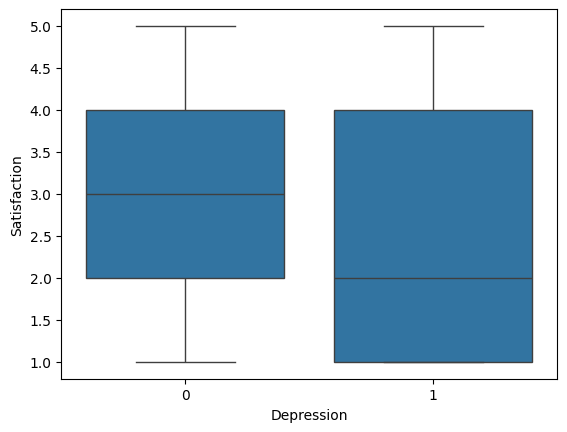

In [6]:
sns.boxplot(train, x="Depression", y="Satisfaction")

<Axes: title={'center': 'Correlation with Depression'}>

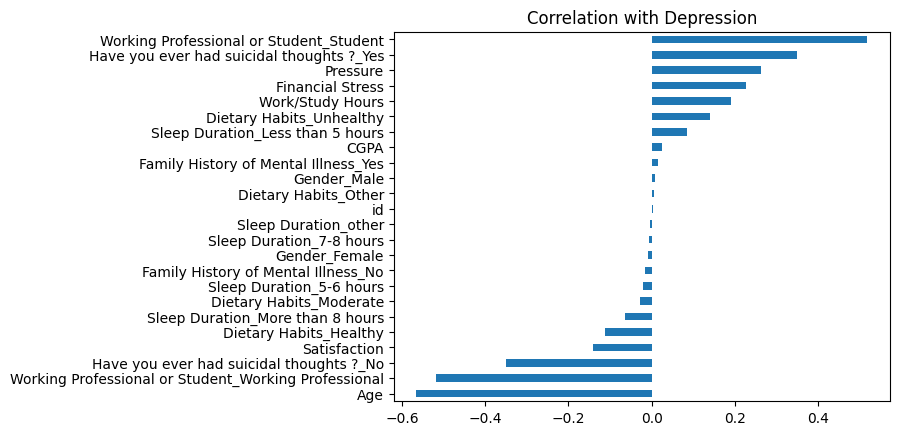

In [7]:
X_train = train.copy()
y_train = X_train.pop("Depression")
corr = X_train.corrwith(y_train).sort_values()
corr.plot.barh(title="Correlation with Depression")

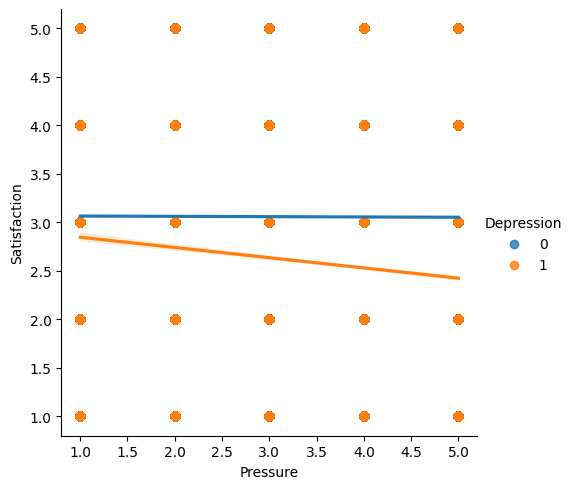

In [8]:
sns.lmplot(train, x="Pressure", y="Satisfaction", hue="Depression")

Text(0.5, 1.0, 'Depression Rate by Sleep Duration')

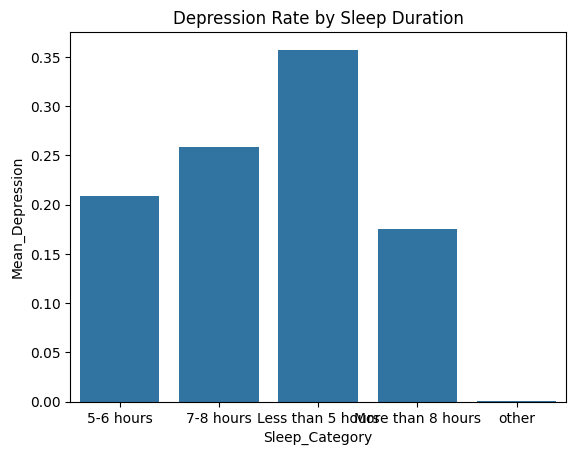

In [9]:
# Get all sleep duration columns
sleep_cols = [col for col in X_train.columns if col.startswith("Sleep Duration_")]

# Plot mean depression per category
sleep_depression = pd.DataFrame({
    "Sleep_Category": [col.replace("Sleep Duration_", "") for col in sleep_cols],
    "Mean_Depression": [X_train[y_train == 1][col].mean() for col in sleep_cols]
})

sns.barplot(data=sleep_depression, x="Sleep_Category", y="Mean_Depression")
plt.title("Depression Rate by Sleep Duration")

Text(0.5, 1.0, 'Depression Rate by Dietary Habits')

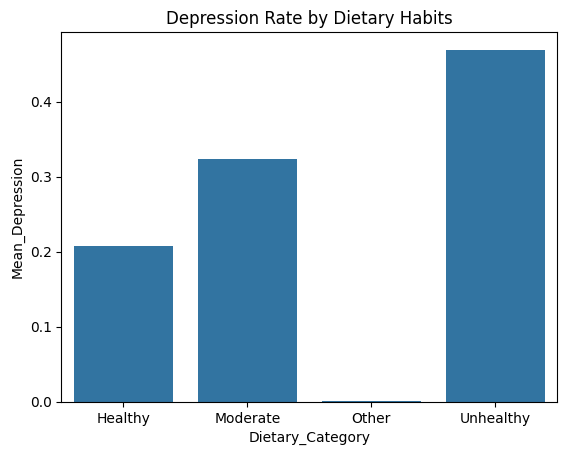

In [10]:
# Get all dietary habits columns
sleep_cols = [col for col in X_train.columns if col.startswith("Dietary Habits_")]

# Plot mean depression per category
sleep_depression = pd.DataFrame({
    "Dietary_Category": [col.replace("Dietary Habits_", "") for col in sleep_cols],
    "Mean_Depression": [X_train[y_train == 1][col].mean() for col in sleep_cols]
})

sns.barplot(data=sleep_depression, x="Dietary_Category", y="Mean_Depression")
plt.title("Depression Rate by Dietary Habits")

## Mutual Information

<Axes: title={'center': 'Mutual Information with Depression'}>

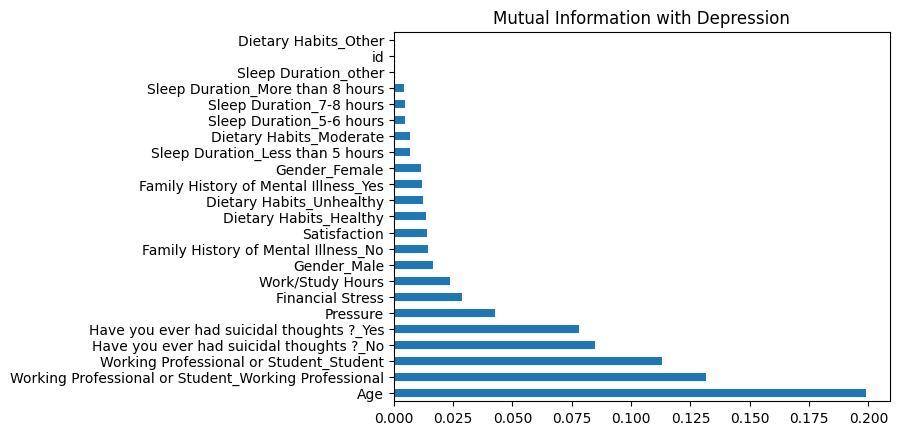

In [11]:
from sklearn.feature_selection import mutual_info_classif

X_train_mi = X_train.drop(columns="CGPA")
mi = mutual_info_classif(X_train_mi, y_train, random_state=0)
mi_series = pd.Series(mi, index=X_train_mi.columns).sort_values(ascending=False)
mi_series.plot.barh(title="Mutual Information with Depression")

In [12]:
X_train["Pressure_Satisfaction_Ratio"] = X_train["Pressure"] / (X_train["Satisfaction"] + 1e-6)
X_val = val.copy()
y_val = X_val.pop("Depression")
X_val["Pressure_Satisfaction_Ratio"] = X_val["Pressure"] / (X_val["Satisfaction"] + 1e-6)

In [13]:
#X_train["Stress_Binned"] = pd.cut(X_train["Financial Stress"], bins=3, labels=["Low", "Medium", "High"])
#X_val["Stress_Binned"] = pd.cut(X_val["Financial Stress"], bins=3, labels=["Low", "Medium", "High"])

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state = 0)

# Baseline (original features)
model.fit(train.drop(columns="Depression"), train["Depression"])
new_acc = accuracy_score(val["Depression"], model.predict(val.drop(columns="Depression")))

# With new features
model.fit(X_train, y_train)
baseline_acc = accuracy_score(y_val, model.predict(X_val))

print(f"Baseline: {baseline_acc:.3f}, With Features: {new_acc:.3f}")

Baseline: 0.937, With Features: 0.936
